In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams.update(tex_fonts)


matplotlib.rc('lines', linewidth=2, markersize=3)

def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 500.02908
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
import pandas as pd
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [4]:
#### WESTERN EUROPE ####
df_list = []
df = pd.read_csv('Data FAO/FAOSTAT_AREA.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_YIELD.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_PESTICIDE.csv')
df_list.append(df)
df_Price = pd.read_csv('Data FAO/commodity-price-index-cereal-crops-and-petroleum.csv')
df_Price = df_Price.rename(columns={"Wheat": "Value"})
condition = df_Price['Year'] >= 1961
df_Price = df_Price[condition]
df_list.append(df_Price)

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize_scalar

np.random.seed(42)

class Landscape:
    def __init__(self, size = 20, frac_conventional = 0.3, frac_organic = 0., frac_natural = 0.7, mean_initial_fertilizer = 40, std_initial_fertilizer = 10, mean_initial_pesticides = 3, std_initial_pesticides = 0.5, \
                    mean_soil_health_agri = 1, std_soil_health_agri = 0,\
                        y_max = 8, Nutrient_uptake_efficiency = 0, Nutrient_release_SOM = 30, N_req = 70, \
                            Maximum_Pest_impact = 0.2, biodiversity_vs_pesticides_protection = 0.3, Pesticides_required = 5, \
                                SOM_rate_conventional = -.02, SOM_rate_organic = 0., SOM_rate_natural = 0.05, biodiversity_organic = 0.0, omega = 0, \
                                    Fertilizer_price = 1, Pesticide_price = 30, fixed_cost_conventional = 500, Fertilizer_choice_profit_impact = 0.2, Fertilizer_choice_other_farmer = 0.1, threshold_base = 0.1, \
                                        subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 0, market_demand_increase = 0.02, market_price_sensitivity = 0.15, markup = 1,
                                                initial_wealth = 1000000, initial_MP = 0.4, investment_fraction = 0, effectiveness_innovation_expenditure = 500, mean_innovation_advancement = 0.012, std_innovation_advancement = 0.0,\
                                                    gamma_F = 0.2):
            
        self.size = size

        # Environmental Parameters
        self.y_max = y_max # Maximum Yield [ton/ha]
        self.Nutrient_uptake_efficiency = Nutrient_uptake_efficiency # Nutrient uptake efficiency 
        self.Nutrient_release_SOM = Nutrient_release_SOM # Nutrient release from SOM decomposition [Kg/ha]
        self.N_req = N_req # Nutrient requirement for growth [ton/ha]
        self.Maximum_Pest_impact = Maximum_Pest_impact # Maximum pest impact 
        self.biodiversity_vs_pesticides_protection = biodiversity_vs_pesticides_protection # Protection potential of biodiversity vs pesticides
        self.Pesticides_required = Pesticides_required # Required Pesticides [kg]
        self.SOM_rate_conventional = SOM_rate_conventional # SOM decomposition rate under conventional farming
        self.SOM_rate_organic = SOM_rate_organic # SOM regeneration rate under organic farming
        self.SOM_rate_natural = SOM_rate_natural # SOM regeneration rate under natural 
        self.biodiversity_organic = biodiversity_organic # Biodiversity contribution from organic
        self.omega = omega

        # Economic Parameters
        self.Fertilizer_price = Fertilizer_price # Cost per kilogram of fertilizer
        self.Pesticide_price = Pesticide_price # Cost per kilogram of pesticide
        self.fixed_cost_conventional = fixed_cost_conventional # Fixed cost for conventional production
        self.Fertilizer_choice_profit_impact = Fertilizer_choice_profit_impact
        self.Fertilizer_choice_other_farmer = Fertilizer_choice_other_farmer
        self.threshold_base = threshold_base # Production switch threshold 
        self.market_demand_increase = market_demand_increase
        self.market_price_sensitivity = market_price_sensitivity
        self.markup = markup
        self.initial_wealth = initial_wealth
        self.investment_fraction = investment_fraction
        self.effectiveness_innovation_expenditure = effectiveness_innovation_expenditure
        self.mean_innovation_advancement = mean_innovation_advancement
        self.std_innovation_advancement = std_innovation_advancement
        self.gamma_F = gamma_F

        # Policy Parameters
        self.subsidy_strength_production = subsidy_strength_production
        self.subsidy_strength_organic = subsidy_strength_organic
        self.policy_strength_natural = policy_strength_natural


        # Initialize matrices
        if frac_conventional + frac_natural + frac_organic != 1:
            raise AttributeError("Input the right amount of initial fractions")
        
        self.initialize_land_types(frac_conventional, frac_organic, frac_natural)
        self.soil_health, self.biodiversity = self.initialize_soil_health_and_biodiversity(mean_soil_health_agri, std_soil_health_agri)

        # Calculate initial productivity
        self.ManagementPractices = initial_MP *  np.ones((self.size, self.size))
        self.pesticides = (self.land_type == 'C') * np.clip(np.random.normal(mean_initial_pesticides, std_initial_pesticides, (size, size)), 1e-3, np.inf)
        self.fertilizer = (self.land_type == 'C') * np.clip(np.random.normal(mean_initial_fertilizer, std_initial_fertilizer, (size, size)), 1e-3, np.inf)
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)
        self.initial_productivity = np.sum(self.productivity)
        self.market_demand = self.initial_productivity
        self.costs = (self.land_type == 'C') * (self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, np.nan))
        self.prices = self.markup * self.costs / self.productivity
        self.market_price =  np.max(self.prices[self.prices > 0])
        self.profits = self.market_price * self.productivity - self.costs
        self.profit_average = self.profits
        self.wealth = self.initial_wealth * np.ones((self.size, self.size))
        self.invested_wealth = np.zeros((self.size, self.size))
        self.selling_matrix = np.ones((self.size, self.size))

        # Initialize data for plotting
        self.data = {'total_productivity': [], 'demand': [], 'O': [], 'C': [], 'N':[], 'market_price': [], 'total_economic_value': [], 'land_type_changes': [], \
                     'mean_Y': [], 'std_Y': [], 'mean_F':[], 'std_F':[], 'mean_P': [], 'std_P':[], 'mean_Soil':[], 'std_Soil':[], 'mean_BIO':[], 'std_BIO':[], 'mean_Profit':[], 'std_Profit':[], \
                         'mean_Price':[], 'std_Price':[], 'mean_wealth':[], 'std_wealth':[], 'mean_MP': [], 'std_MP':[] }

    def initialize_land_types(self, frac_conventional, frac_organic, frac_natural):
        total_cells = self.size * self.size
        num_conventional = int(total_cells * frac_conventional)
        num_organic = int(total_cells * frac_organic)
        num_natural = total_cells - num_conventional - num_organic

        land_types_flat = (['C'] * num_conventional +
                           ['O'] * num_organic +
                           ['N'] * num_natural)

        np.random.shuffle(land_types_flat)
        self.land_type = np.array(land_types_flat).reshape((self.size, self.size))

    def initialize_soil_health_and_biodiversity(self, mean, std):
        soil_health = np.zeros((self.size, self.size))
        soil_health[self.land_type != 'N'] = np.random.normal(mean, std, (self.size, self.size))[self.land_type != 'N']
        soil_health[self.land_type == 'N'] = 1
        soil_health = np.clip(soil_health, 0, 1)
        
        biodiversity = np.zeros((self.size, self.size))
        biodiversity[self.land_type == 'N'] = 1
        biodiversity[self.land_type != 'N'] = 0.6

        return soil_health, biodiversity
    
    def update_soil_health(self):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.soil_health, kernel, mode='wrap')

        delta_h = np.where(self.land_type == 'O', self.SOM_rate_organic, self.SOM_rate_conventional)
        delta_h[self.land_type == 'N'] = self.SOM_rate_natural
        self.soil_health += (delta_h + self.omega * avg_neighbors) * self.soil_health
        self.land_type[self.soil_health < 0] = 'N'
        self.wealth[self.soil_health < 0] = 0
        self.soil_health = np.clip(self.soil_health, 0, 1)

    def update_biodiversity(self):

        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.biodiversity, kernel, mode='wrap')
        delta_b = np.where(self.land_type == 'O', 0.01, -0.05)
        delta_b[self.land_type == 'N'] = 0.05
        self.biodiversity += (delta_b + self.omega * avg_neighbors) * self.biodiversity
        self.biodiversity = np.clip(self.biodiversity, 0, 1)
    
    def productionfunction(self, fertilizer, pesticide):

        production =  self.y_max * self.ManagementPractices * (1 - np.exp(-1/self.N_req * ( self.soil_health**self.Nutrient_uptake_efficiency  * fertilizer + self.Nutrient_release_SOM * self.soil_health))) \
                        * (1 - self.Maximum_Pest_impact * np.exp( - self.biodiversity_vs_pesticides_protection * self.biodiversity - (1 - self.biodiversity_vs_pesticides_protection) * pesticide / self.Pesticides_required)) \
                            * (1 + np.random.normal(0, 0.0, (self.size, self.size)))\
                                * (self.land_type != "N")
        return production
    
    def optimization_function(self, fertilizer, pesticide, expected_market_price, x, y):

        production =  self.y_max * (1 - np.exp(-1/self.N_req * ( self.ManagementPractices[x,y] * fertilizer + self.Nutrient_release_SOM * self.soil_health[x, y]))) \
                        * (1 - self.Maximum_Pest_impact * np.exp( - self.biodiversity_vs_pesticides_protection * self.biodiversity[x, y] - (1 - self.biodiversity_vs_pesticides_protection) * pesticide / self.Pesticides_required)) 

        profit = production * expected_market_price - self.Fertilizer_price * fertilizer - self.Pesticide_price * pesticide - self.fixed_cost_conventional

        return profit
    
    def planning_phase(self):
        expected_market_price = self.market_price #* ( 1 +  4  * (self.market_demand - np.sum(self.productivity[self.land_type == 'C']))/ self.market_demand)
        print('expected_market_price vs market_price')
        print(expected_market_price, self.market_price)

        gamma_P = 0.2 # * self.Maximum_Pest_impact * (1 - self.biodiversity_vs_pesticides_protection) * self.N_req / self.Pesticides_required

        # F_opt = np.zeros((self.size, self.size))
        # P_opt = np.zeros((self.size, self.size))
        # for i, pos in enumerate(np.argwhere(self.land_type == 'C')):
        #     x, y = pos
        #     if self.wealth[x, y] > 0:
        #         results = minimize(lambda F_P: - self.optimization_function(F_P[0], F_P[1],expected_market_price, x, y), x0 = [self.fertilizer[x,y], self.pesticides[x,y]], bounds = [(0, self.wealth[x, y]/self.Fertilizer_price), (0, self.wealth[x, y]/self.Pesticide_price)])
        #         F_opt[x, y], P_opt[x,y] = results.x
            
        # Fertilizer_change = np.linspace(0.5,1.5,10)
        # Pest_change = np.linspace(0.5,1.5,10)
        # mesh = np.array(np.meshgrid(Fertilizer_change, Pest_change)).T.reshape(-1,2)
        # self.profit_average = 0.7 * self.profit_average + 0.3 * self.profits 

        # production = np.sum(self.productivity[self.land_type == 'C'])
        # mask = np.zeros((self.size, self.size))
        # mask[(self.selling_matrix == 1) & (self.profits <= 0)] = -1
        # mask[(self.selling_matrix == 1) & (self.profits > 0)] = 1
        # mask[(self.selling_matrix < 1) & (self.profits < 0)] = 1
        # mask[(self.selling_matrix < 1) & (self.profits >= 0)] = -1
        # mask[self.profits >= 0] = 1
        # mask[self.profits < 0] = -1
        # print((self.profits / self.profit_average)[self.land_type == 'C'])
        # F_pro = self.fertilizer * (1 + self.gamma_F * mask * np.random.rand(self.size, self.size))
        # print(F_pro)
        # P_pro = self.pesticides * (1 + gamma_P * mask * np.random.rand(self.size, self.size))
        # F_target  = (1 - self.Fertilizer_choice_profit_impact) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_pro
        # F_target = (1 - self.Fertilizer_choice_other_farmer) * F_pro + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C'])
        # P_target = (1 - self.Fertilizer_choice_other_farmer) * P_pro + self.Fertilizer_choice_other_farmer * np.mean(self.pesticides[self.land_type == 'C'])

        # fertilizer = F_pro #np.minimum(1, self.wealth / (self.Fertilizer_price * F_target)) * F_target
        # pesticides = np.minimum(1, self.wealth / (self.Fertilizer_price * F_target + self.Pesticide_price * P_target)) * P_target

        # F_try = self.fertilizer * mesh[:,0][:, np.newaxis, np.newaxis]
        # P_try = self.pesticides * mesh[:,1][:, np.newaxis, np.newaxis]

        # Profit_try = (expected_market_price + self.subsidy_strength_production) * self.productionfunction(F_try, P_try) - self.Fertilizer_price * F_try - self.Pesticide_price * P_try - self.fixed_cost_conventional
        # # print(np.max(P_try, axis = 0) * (self.land_type != 'N'))
        # F_opt = F_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        # P_opt = P_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        # F_opt =  - self.N_req * np.log(self.N_req * self.Fertilizer_price / (expected_market_price * self.y_max * self.selling_matrix)) - self.Nutrient_release_SOM * self.soil_health
        # market_share = self.productivity / np.sum(self.productivity[self.land_type == 'C'])
        probabile_fraction_sold = np.minimum(1, self.market_demand / np.sum(self.productivity[self.land_type == 'C']))
        # print(probabile_fraction_sold)
        # F_opt =  - self.N_req * np.log(- (market_share - 1) * self.N_req * self.Fertilizer_price / ((1 - market_share) * expected_market_price * probabile_fraction_sold * self.y_max)) #- self.Nutrient_release_SOM * self.soil_health
        # Profit_opt = (1 - market_share) *  self.market_price * probabile_fraction_sold *  self.y_max * (1 - np.exp(-1/self.N_req * self.fertilizer)) - (market_share - 1) * self.Fertilizer_price * self.fertilizer - self.fixed_cost_conventional
        print(probabile_fraction_sold)
        F_opt =  - self.N_req * np.log(self.N_req * self.Fertilizer_price / (expected_market_price * probabile_fraction_sold * self.y_max)) #- self.Nutrient_release_SOM * self.soil_health
        Profit_opt = self.market_price * probabile_fraction_sold *  self.y_max * (1 - np.exp(-1/self.N_req * F_opt)) - self.Fertilizer_price * F_opt - self.fixed_cost_conventional
        # F_D = - self.N_req * np.log(1-self.market_demand / np.sum(self.land_type=='C') / self.y_max)
        # profit_D = self.market_price * self.y_max * (1 - np.exp(-1/self.N_req * F_D)) - self.Fertilizer_price * F_D - self.fixed_cost_conventional
        
        # F_opt = F_D if profit_D > Profit_opt else F_opt
        print('F_opt')
        print(F_opt)
        print('Profit_opt')
        print(Profit_opt)
        # print(F_opt, self.Fertilizer_price * F_opt - self.fixed_cost_conventional)
        # kernel = np.array([[1, 1, 1],
        #                    [1, 0, 1],
        #                    [1, 1, 1]]) / 8.0
        # avg_fertilizer_neighbors = convolve(self.fertilizer * (self.land_type == 'C'), kernel, mode='wrap')
        # print(self.wealth/self.Fertilizer_price > (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C']))
        # fertilizer = np.minimum(np.maximum(self.wealth - self.fixed_cost_conventional, 0)/self.Fertilizer_price, (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C']))#np.minimum(np.maximum(self.wealth, 0)/self.Fertilizer_price, (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C']))
        # pesticide = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.pesticides + self.Fertilizer_choice_profit_impact * P_opt + self.Fertilizer_choice_other_farmer * np.mean(self.pesticides[self.land_type == 'C'])
        fertilizer = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C'])#np.minimum(np.maximum(self.wealth, 0)/self.Fertilizer_price, (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C']))

        return fertilizer * (self.land_type != 'N'), np.zeros((self.size, self.size)) * (self.land_type != 'N')

    def computecosts(self):
        return self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, 0)
    
    def computeprices(self):
        return (self.land_type == 'C') * self.markup * self.costs / np.where(self.productivity > 0, self.productivity, 1)

    def compute_sellingmatrix_price(self):
        # Flatten and sort the production values along with their indices
        flattened_productivity = self.productivity.ravel()
        sorted_indices = np.argsort(flattened_productivity)[::-1]
        sorted_productivity = flattened_productivity[sorted_indices]

        # Calculate sold fractions
        cumulative_production = np.cumsum(sorted_productivity)
        sold_fraction = np.zeros_like(sorted_productivity)

        # Find the index where demand is just met or exceeded
        meet_demand_index = np.argmax(cumulative_production >= self.market_demand)

        # If demand is less than or equal to total production
        if cumulative_production[meet_demand_index] >= self.market_demand:
            # Units fully sold
            sold_fraction[:meet_demand_index] = 1
            # The last unit might be partially sold
            if cumulative_production[meet_demand_index] > self.market_demand:
                if meet_demand_index == 0:
                    sold_fraction[meet_demand_index] = (self.market_demand) / sorted_productivity[meet_demand_index]
                else:
                    sold_fraction[meet_demand_index] = (self.market_demand - cumulative_production[meet_demand_index - 1]) / sorted_productivity[meet_demand_index]
        else:
            # All units are sold
            sold_fraction[:] = 1

        market_price = self.prices.ravel()[sorted_indices][meet_demand_index]

        # Reconstruct the matrix with the sold fractions in their original positions
        reconstructed_matrix = np.zeros_like(sold_fraction)
        reconstructed_matrix[sorted_indices] = sold_fraction
        return reconstructed_matrix.reshape(self.productivity.shape), market_price
    
    def computeprofit(self):
        self.selling_matrix, self.proposed_price = self.compute_sellingmatrix_price()
        
        # selling_matrix = np.ones((self.size, self.size))
        self.market_price = 0.9 *  self.market_price + 0.1 * self.proposed_price
        # print(selling_matrix, self.market_price, self.prices)
        profit = (self.land_type != 'N') * ( self.selling_matrix * self.market_price *  self.productivity - self.costs)   #(selling_matrix * self.productivity * (self.market_price + self.subsidy_strength_production) \
                                            # - self.Fertilizer_price * self.fertilizer \
                                            #     - self.Pesticide_price * self.pesticides \
                                            #         + np.where(self.land_type == 'O', self.subsidy_strength_organic, 0) \
                                            #             - np.where(self.land_type == 'C', self.fixed_cost_conventional, 0))

        print('fertilizer')
        print(self.fertilizer)
        print('productivity')
        print(self.productivity)
        print('Selling matrix')
        print(self.selling_matrix)
        print('Profit')
        print(profit)
        print('----')
        return profit
    
    def update_productivity_and_economic_value(self):
        self.fertilizer, self.pesticides = self.planning_phase()
        
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)  
        self.costs =  self.computecosts()      
        self.prices = self.computeprices()
        self.profits = self.computeprofit()
        self.wealth += self.profits
        bankrupt = self.wealth < -1
        # if np.sum(bankrupt) > 0:
        #     print(np.sum(bankrupt))
        #     raise
        # print(self.wealth)
        # self.land_type[bankrupt] = 'N'
        # self.wealth[bankrupt] = np.mean(self.wealth[self.land_type == 'C'])

        # self.fertilizer[bankrupt] = np.mean(self.fertilizer[self.land_type == 'C'])
        # self.land_type[bankrupt] = 'C'

    def investment_decision(self):

        self.invested_wealth += (self.investment_fraction * self.wealth) * (self.wealth > 0)
        self.wealth -= (self.investment_fraction * self.wealth) * (self.wealth > 0)
        
        farms_innovating = np.random.rand(self.size, self.size) < 1 - np.exp(- 1/self.effectiveness_innovation_expenditure * self.invested_wealth) 

        self.invested_wealth[farms_innovating] = 0
        innovation = farms_innovating * self.mean_innovation_advancement #* (1 + np.random.normal(0, self.std_innovation_advancement, (self.size, self.size)))#np.random.normal(mean_innovation_advancement, std_innovation_advancement, (self.size, self.size))

        self.ManagementPractices[farms_innovating] += innovation[farms_innovating]

    def update_demand(self):
        self.market_demand += self.market_demand_increase * self.initial_productivity 
    
    def update_market_price(self):
        self.market_price = 0. * self.proposed_price + 1 * self.market_price * (1 + self.market_price_sensitivity * (self.market_demand - np.sum(self.productivity[self.land_type == 'C'])) / np.sum(self.productivity[self.land_type == 'C']))    
        
    def simulate_year(self):
        self.aggregate_data()
        self.update_productivity_and_economic_value()
        self.investment_decision()
        self.update_soil_health()
        self.update_biodiversity()
        self.update_demand()
        # self.update_market_price()

    def simulation(self):
        for _ in range(100):
            self.simulate_year()
        
    def aggregate_data(self):
        self.data['total_productivity'].append(np.sum(self.productivity))
        self.data['demand'].append(self.market_demand)
        self.data['market_price'].append(self.market_price)
        self.data['total_economic_value'].append(np.sum(self.wealth))
        self.data['N'].append(np.sum(self.land_type=='N') / self.size**2)
        self.data['O'].append(np.sum(self.land_type=='O') / self.size**2)
        self.data['C'].append(np.sum(self.land_type=='C') / self.size**2)
        self.data['mean_Y'].append(np.mean(self.productivity[self.land_type!='N']))
        self.data['std_Y'].append(np.std(self.productivity[self.land_type!='N']))
        self.data['mean_F'].append(np.mean(self.fertilizer[self.land_type !='N']))
        self.data['std_F'].append(np.std(self.fertilizer[self.land_type!='N']))
        self.data['mean_P'].append(np.mean(self.pesticides[self.land_type!='N']))
        self.data['std_P'].append(np.std(self.pesticides[self.land_type!='N']))
        self.data['mean_Soil'].append(np.mean(self.soil_health[self.land_type!='N']))
        self.data['std_Soil'].append(np.std(self.soil_health[self.land_type!='N']))
        self.data['mean_BIO'].append(np.mean(self.biodiversity[self.land_type!='N']))
        self.data['std_BIO'].append(np.std(self.biodiversity[self.land_type!='N']))
        self.data['mean_Profit'].append(np.mean(self.profits[self.land_type!='N']))
        self.data['std_Profit'].append(np.std(self.profits[self.land_type!='N']))
        self.data['mean_Price'].append(np.mean(self.prices[self.land_type!='N']))
        self.data['std_Price'].append(np.std(self.prices[self.land_type!='N']))
        self.data['mean_wealth'].append(np.mean(self.wealth[self.land_type!='N']))
        self.data['std_wealth'].append(np.std(self.wealth[self.land_type!='N'])) 
        self.data['mean_MP'].append(np.mean(self.ManagementPractices[self.land_type!='N']))
        self.data['std_MP'].append(np.std(self.ManagementPractices[self.land_type!='N']))    

        # Additional data aggregation can be added here

    def plot_aggregated_data(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        years = np.arange(1961, 1961 + len(self.data['mean_F']))

        ax = axes[0]
        ax.plot(years, self.data['total_productivity'], label='Total Productivity')
        ax.plot(years, self.data['demand'], label = 'demand')
        ax.legend()

        ax = axes[1]
        ax.plot(years, self.data['N'], label='N', color='g')
        ax.plot(years, self.data['O'], label='O', color='b')
        ax.plot(years, self.data['C'], label='C', color='r')
        ax.legend()

        ax = axes[2]
        ax.plot(years, self.data['market_price'], label='market price')
        ax.legend()

        plt.show()

    def plot_mean_data(self):
       
        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(17, 5))
        years = np.arange(1961, 1961 + len(self.data['mean_F']))
        axes = axes.ravel()

        # Yield
        ax = axes[0]
        ax.plot(years, self.data['mean_Y'], label='Mean Yield (ton/ha)')
        ax.fill_between(years, np.array(self.data['mean_Y']) - np.array(self.data['std_Y']), np.array(self.data['mean_Y']) + np.array(self.data['std_Y']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/crop_yields.csv')
        # condition = (df['country'] == 'France') & (df['year'] >= 1961)
        # ax.plot(df[condition]['year'], df[condition]['wheat_yield'], label ='France', linestyle = '--')

        ax.set_title('Mean Yield (ton/ha)')
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield (ton/ha)')
        ax.legend()

        # Fertilizer Use
        ax = axes[1]
        ax.plot(years, self.data['mean_F'], label='Mean Fertilizer Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_F']) - np.array(self.data['std_F']), np.array(self.data['mean_F']) + np.array(self.data['std_F']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Fertilizer Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Fertilizer Use (kg/ha)')
        ax.legend()

        # Pesticedes Use
        ax = axes[2]
        ax.plot(years, self.data['mean_P'], label='Mean Pesticides Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_P']) - np.array(self.data['std_P']), np.array(self.data['mean_P']) + np.array(self.data['std_P']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Pesticides Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Pesticides Use (kg/ha)')
        ax.legend()

        # Soil Organic Matter
        ax = axes[3]
        ax.plot(years, 5 * np.array(self.data['mean_Soil']), label='Mean Soil')
        ax.fill_between(years, 5 * np.array(self.data['mean_Soil']) - 5 * np.array(self.data['std_Soil']), 5 * np.array(self.data['mean_Soil']) + 5 * np.array(self.data['std_Soil']), alpha=0.2)
        ax.set_title('Mean Soil Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Soil')
        ax.legend()

        # Profits
        ax = axes[4]
        ax.plot(years, self.data['mean_Profit'], label='Mean Profit')
        ax.fill_between(years, np.array(self.data['mean_Profit']) - np.array(self.data['std_Profit']), np.array(self.data['mean_Profit']) + np.array(self.data['std_Profit']), alpha=0.2)
        ax.set_title('Mean Profit Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Profit')
        ax.legend()

        ax = axes[5]
        ax.plot(years, self.data['mean_wealth'], label='Mean Wealth')
        ax.fill_between(years, np.array(self.data['mean_wealth']) - np.array(self.data['std_wealth']), np.array(self.data['mean_wealth']) + np.array(self.data['std_wealth']), alpha=0.2)
        ax.set_title('Mean Wealth Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Wealth')
        ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_data_comparison(self, df_list, title):

        fig = plt.figure(figsize=(17,10))
        fig.suptitle(title, fontsize = 20)
        gs = GridSpec(nrows=4, ncols=8)
        years = np.arange(1961, 1961 + len(self.data['mean_F']))

        # Plot 2
        ax = fig.add_subplot(gs[0, 1:3])
        color = 'k'
        # ax.plot(years, np.array(self.data['N']) * 100, c = color, ls = '--', label='N')
        ax.plot(years, np.array(self.data['total_productivity']), c = color, label=r'$\mathcal{Y}$')
        ax.plot(years, np.array(self.data['demand']), ls='--', c = color, label=r'$\mathcal{D}$')
        ax.set_ylabel('Production [ton]')
        ax.grid(alpha = 0.2)
        ax.legend()

        # Plot 3
        ax = fig.add_subplot(gs[0, 3:5])
        color = 'k'
        ax.plot(years, self.data['market_price']/self.data['market_price'][0]*100, c = color, label='Model')
        df = df_list[-1]
        ax.plot(df['Year'], df['Value']/df['Value'].iloc[0]*100, c = 'brown', ls = ':', label = 'Real Data')
        ax.set_ylabel('Market Price Index')
        ax.grid(alpha = 0.2)
        ax.legend() 

        # Plot 4
        ax = fig.add_subplot(gs[0, 5:7])
        ax.plot(years, self.data['mean_MP'], c=color, label='Model')
        ax.fill_between(years, np.array(self.data['mean_MP']) - np.array(self.data['std_MP']), np.array(self.data['mean_MP']) + np.array(self.data['std_MP']), color=color, alpha=0.2)
        ax.set_xlabel('Year')
        ax.set_ylabel('MP')


        # Plot 2
        ax = fig.add_subplot(gs[1, :2])
        df = df_list[0]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)
        std = np.nanstd(df_pivot, axis= 1)
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        # ax.plot(years, np.array(self.data['N']) * 100, c = color, ls = '--', label='N')
        ax.plot(years, np.array(self.data['C']) * 100, c = color, label='Model')
        ax.set_ylabel('Agricultural Land Fraction [\%]')
        ax.grid(alpha = 0.2)
        # ax.legend()


        # Plot 4
        ax = fig.add_subplot(gs[1, 2:4])
        df = df_list[1]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)/10000
        std = np.nanstd(df_pivot, axis= 1)/10000
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        ax.plot(years, self.data['mean_Y'], label='Model', c=color)
        ax.fill_between(years, np.array(self.data['mean_Y']) - np.array(self.data['std_Y']), np.array(self.data['mean_Y']) + np.array(self.data['std_Y']), color = color, alpha=0.2)
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield [ton/ha]')
        ax.grid(alpha = 0.2)
        # ax.legend()

        # Plot 5
        ax = fig.add_subplot(gs[1, 4:6])
        df = df_list[2]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)
        std = np.nanstd(df_pivot, axis= 1)
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        ax.plot(years, self.data['mean_F'], c=color, label='Model')
        ax.fill_between(years, np.array(self.data['mean_F']) - np.array(self.data['std_F']), np.array(self.data['mean_F']) + np.array(self.data['std_F']), color=color, alpha=0.2)
        ax.set_xlabel('Year')
        ax.set_ylabel('Fertilizer Use [kg/ha]')
        ax.grid(alpha = 0.2)
        # ax.legend()

        # Plot 6
        ax = fig.add_subplot(gs[1, 6:])
        df = df_list[3]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)
        std = np.nanstd(df_pivot, axis= 1)
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        ax.plot(years, self.data['mean_P'], c=color, label='Model')
        ax.fill_between(years, np.array(self.data['mean_P']) - np.array(self.data['std_P']), np.array(self.data['mean_P']) + np.array(self.data['std_P']), color=color, alpha=0.2)
        ax.set_xlabel('Year')
        ax.set_ylabel('Pesticide Use [kg/ha]')
        ax.grid(alpha = 0.2)
        # ax.legend()

        # Plot 7
        ax = fig.add_subplot(gs[2, 1:3])
        ax.plot(years, np.array(self.data['mean_Price']), label=r'$p_i$', c='k')
        ax.fill_between(years, np.clip(np.array(self.data['mean_Price']) - np.array(self.data['std_Price']), 0, np.inf), np.array(self.data['mean_Price']) + np.array(self.data['std_Price']), alpha=0.2, color = 'k')
        ax.plot(years, self.data['market_price'], ls = '--', label = r'$p^M$', c='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Prices [€/ton]')
        ax.grid(alpha = 0.2)
        ax.legend()

        # Plot 8
        ax = fig.add_subplot(gs[2, 3:5])
        ax.plot(years, self.data['mean_Profit'], label='Mean Profit', c='k')
        ax.fill_between(years, np.array(self.data['mean_Profit']) - np.array(self.data['std_Profit']), np.array(self.data['mean_Profit']) + np.array(self.data['std_Profit']), alpha=0.2, color = 'k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Profit [€]')
        ax.grid(alpha = 0.2)


        # Plot 9
        ax = fig.add_subplot(gs[2, 5:7])
        ax.plot(years, self.data['mean_wealth'], label='Mean Wealth', c = 'k')
        ax.fill_between(years, np.array(self.data['mean_wealth']) - np.array(self.data['std_wealth']), np.array(self.data['mean_wealth']) + np.array(self.data['std_wealth']), alpha=0.2, color ='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Wealth [€]')
        ax.grid(alpha = 0.2)


        # Plot 10
        ax = fig.add_subplot(gs[3, 1:4])
        ax.plot(years, 5 * np.array(self.data['mean_Soil']), label='Mean Soil', c='k')
        ax.fill_between(years, 5 * np.array(self.data['mean_Soil']) - 5 * np.array(self.data['std_Soil']), 5 * np.array(self.data['mean_Soil']) + 5 * np.array(self.data['std_Soil']), alpha=0.2, color ='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean SOM [\%]')
        ax.grid(alpha = 0.2)


        # Plot 11
        ax = fig.add_subplot(gs[3, 4:7])
        ax.plot(years, np.array(self.data['mean_BIO']), label='Mean BIO', c='k')
        ax.fill_between(years, np.array(self.data['mean_BIO']) - np.array(self.data['std_BIO']), np.array(self.data['mean_BIO']) + np.array(self.data['std_BIO']), alpha=0.2, color ='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Bio')
        ax.grid(alpha = 0.2)

    def plot_spatial_data(self):

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(self.soil_health, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 0].set_title('Soil Health')
        axs[0, 1].imshow(self.biodiversity, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 1].set_title('Biodiversity')
        axs[1, 0].imshow(self.productivity, cmap='YlOrRd', vmin = 0, vmax = 1)
        axs[1, 0].set_title('Productivity')
        axs[1, 1].imshow(self.wealth, cmap='YlOrRd')
        axs[1, 1].set_title('Economic Value')
  
        for axes in axs.reshape(-1):
            for (j,i), label in np.ndenumerate(self.land_type):
                axes.text(i,j,label,ha='center',va='center')
                axes.text(i,j,label,ha='center',va='center')

        plt.show()


In [131]:

landscape = Landscape(size = 2, frac_conventional = 1, frac_organic = 0., frac_natural = 0., mean_initial_fertilizer = 50, std_initial_fertilizer = 10, mean_initial_pesticides = 0, std_initial_pesticides = 0., \
                    mean_soil_health_agri = 1, std_soil_health_agri = 0,\
                        y_max = 9, Nutrient_release_SOM = 0, N_req = 60, \
                            Maximum_Pest_impact = 0., biodiversity_vs_pesticides_protection = 0.3, Pesticides_required = 2, \
                                SOM_rate_conventional = -.02, SOM_rate_organic = 0., SOM_rate_natural = 0.05, biodiversity_organic = 0.0, omega = 0, \
                                    Fertilizer_price = 0.8, Pesticide_price = 10, fixed_cost_conventional = 600, Fertilizer_choice_profit_impact = 0.1, Fertilizer_choice_other_farmer = 0., threshold_base = 0.1, \
                                        subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 0, market_demand_increase = 0.0, market_price_sensitivity = 0.2, markup = 1,
                                                initial_wealth=10000, initial_MP=1, investment_fraction = 0.0, effectiveness_innovation_expenditure=5000, mean_innovation_advancement=0.07, std_innovation_advancement=0,
                                                    gamma_F=0.2)

landscape.simulation()

expected_market_price vs market_price
172.59136662338088 172.59136662338088
1.0
F_opt
208.61701945580242
Profit_opt
738.428684045786
fertilizer
[[61.69094271 61.67013416]
 [68.03936239 48.64217974]]
productivity
[[5.78109191 5.77997537]
 [6.10427589 4.99909101]]
Selling matrix
[[1.         1.        ]
 [1.         0.14900305]]
Profit
[[ 322.52295795  322.35190005]
 [ 371.77559472 -513.6898922 ]]
----
expected_market_price vs market_price
168.11282831194407 168.11282831194407
0.8122957242440111
F_opt
194.56608628814388
Profit_opt
425.363115624722
fertilizer
[[74.97845707 74.95972938]
 [80.69203478 63.2345704 ]]
productivity
[[6.42053084 6.41972559]
 [6.65483132 5.86284898]]
Selling matrix
[[1.         0.83101073]
 [1.         0.        ]]
Profit
[[ 377.45852968  202.04893496]
 [ 410.74637432 -650.58765632]]
----
expected_market_price vs market_price
161.58185691188362 161.58185691188362
0.7260142331189585
F_opt
185.45098650750333
Profit_opt
259.43576218036355
fertilizer
[[86.02571001 86

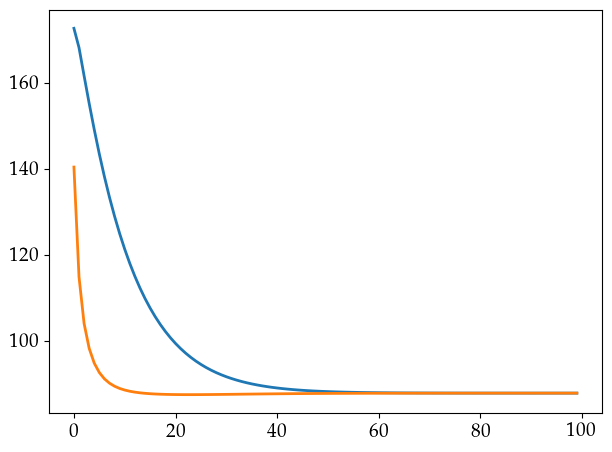

In [132]:
plt.plot(landscape.data['market_price'])
plt.plot(landscape.data['mean_Price'])

In [134]:
landscape.wealth

array([[ 15830.62118456, -36505.41171772],
       [ 16011.30855608, -60379.89478022]])

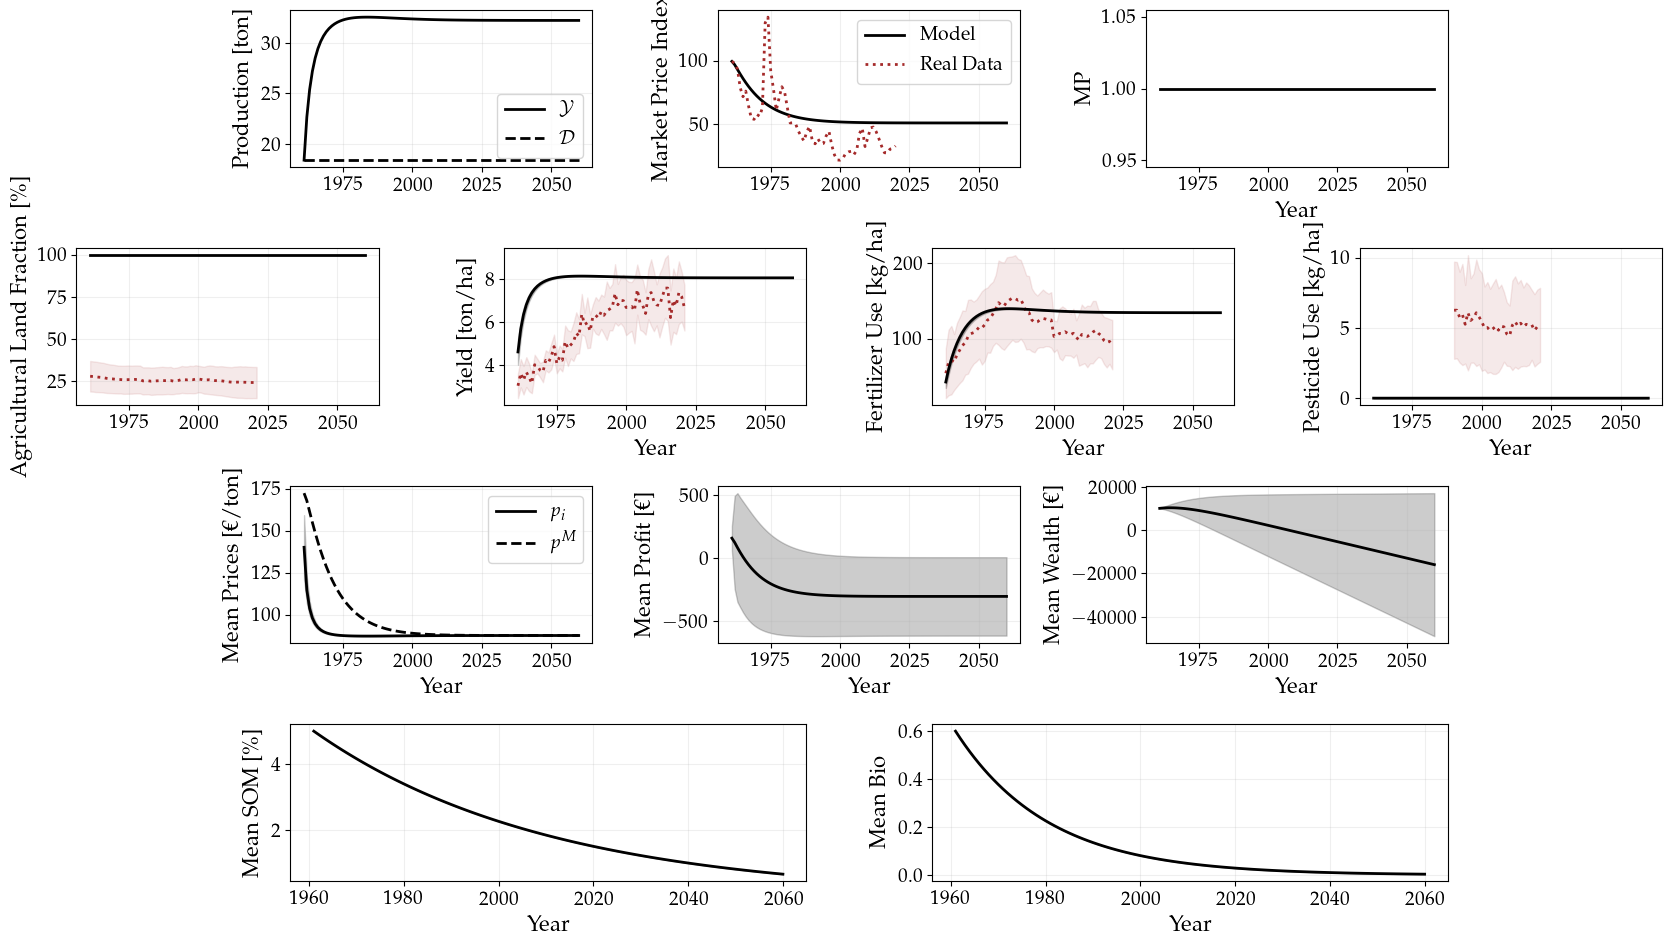

In [133]:
landscape.plot_data_comparison(df_list, '')

In [1241]:
- landscape.N_req * np.log(landscape.N_req * landscape.Fertilizer_price / 80 / landscape.y_max) - landscape.Nutrient_release_SOM * 0.2

176.7729664892466

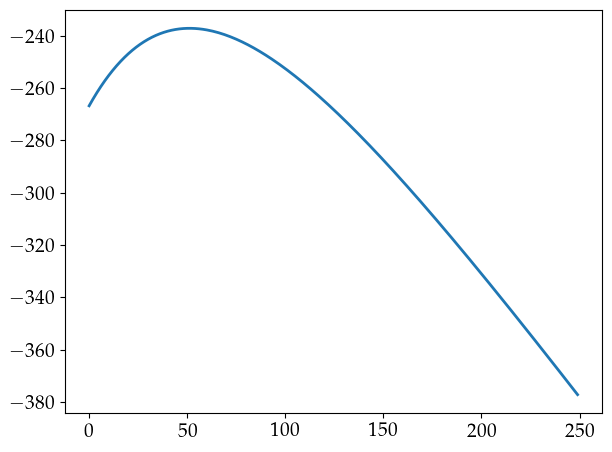

In [11]:
plt.plot(0.3*landscape.y_max*(1 - np.exp(-1/60 *(np.arange(50,300) )))*120 - 1 * np.arange(50,300) - 400)

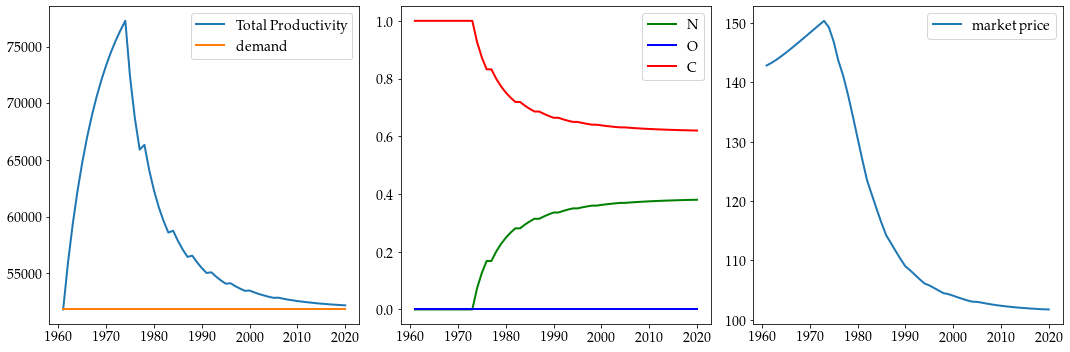

In [1076]:
landscape.plot_aggregated_data()

In [799]:
landscape.market_price 

6.821217754420331

In [ ]:
def func(x,x0):
    return x0 * x**2



In [19]:
from scipy.optimize import minimize_scalar

def func(x, x0):
    return x0 * x**2

# Define a range of values for x0
x0_values = [0.1, 0.5, 1.0, 2.0]

# Initialize variables to store the maximum values and corresponding x for each x0
max_value = -float('inf')
max_x = None
max_bound = np.arange(4)

# Iterate through the x0 values
for i, x0 in enumerate(x0_values):
    # Use a numerical optimization technique to find the maximum within [0, 1]


    result = minimize_scalar(lambda x: -func(x, x0), bounds=(0, max_bound[i]), method='bounded')
    
    # Check if the result is greater than the current maximum
    if -result.fun > max_value:
        max_value = -result.fun
        max_x = result.x

    # Print the maximum value and the corresponding x
    print(f"Maximum value: {max_value}")
    print(f"Corresponding x: {max_x}")


Maximum value: 0.0
Corresponding x: 0.0
Maximum value: 0.49999403915677937
Corresponding x: 0.9999940391390134
Maximum value: 3.9999839798905765
Corresponding x: 1.9999959949686341
Maximum value: 17.999958567522306
Corresponding x: 2.9999965472915386


In [20]:
import numpy as np
from scipy.optimize import minimize_scalar

def func(x, y, x0):
    return x0 * x**2 + y**2 

# Define a range of values for x0
x0_values = np.array([0.1, 0.5, 1.0, 2.0])

# Define the bounds for each x0
max_bounds = np.array([0.2, 0.8, 1.0, 2.0])

# Vectorized optimization using NumPy
def maximize_for_x0(x0):
    result = minimize_scalar(lambda x: -func(x, x0), bounds=(0, max_bounds[x0_values == x0]), method='bounded')
    return -result.fun, result.x

# Apply the vectorized function to all x0 values
max_values, max_x_values = np.vectorize(maximize_for_x0)(x0_values)

# Print the maximum values and corresponding x for each x0
for x0, max_val, max_x in zip(x0_values, max_values, max_x_values):
    print(f"x0 = {x0}, Maximum value: {max_val}, Corresponding x: {max_x}")


x0 = 0.1, Maximum value: 0.003999806603533287, Corresponding x: 0.19999516502988984
x0 = 0.5, Maximum value: 0.31999650344842656, Corresponding x: 0.7999956292985938
x0 = 1.0, Maximum value: 0.9999880783135587, Corresponding x: 0.9999940391390134
x0 = 2.0, Maximum value: 7.999967959781153, Corresponding x: 1.9999959949686341


In [21]:
max_values

array([3.99980660e-03, 3.19996503e-01, 9.99988078e-01, 7.99996796e+00])

In [23]:
import numpy as np
from scipy.optimize import minimize

def func(x, y, x0):
    return x0 * x**2 + y**2

# Define a range of values for x0
x0_values = np.array([0.1, 0.5, 1.0, 2.0])

# Initialize variables to store the maximum values and corresponding x, y for each x0
max_values = np.zeros(len(x0_values))
max_x = np.zeros(len(x0_values))
max_y = np.zeros(len(x0_values))

# Define the bounds for x and y
bounds = [(0, 1), (0, 1)]

# Iterate through the x0 values
for i, x0 in enumerate(x0_values):
    # Use a numerical optimization technique to find the maximum within [0, 1] for both x and y
    result = minimize(lambda xy: -func(xy[0], xy[1], x0), x0=[0.5, 0.5], bounds=bounds)
    
    # Store the maximum value and the corresponding x and y for each x0
    max_values[i] = -result.fun
    max_x[i], max_y[i] = result.x

# Print the maximum values and corresponding x, y for each x0
for x0, max_val, x, y in zip(x0_values, max_values, max_x, max_y):
    print(f"x0 = {x0}, Maximum value: {max_val}, Corresponding x: {x}, Corresponding y: {y}")


x0 = 0.1, Maximum value: 1.1, Corresponding x: 1.0, Corresponding y: 1.0
x0 = 0.5, Maximum value: 1.5, Corresponding x: 1.0, Corresponding y: 1.0
x0 = 1.0, Maximum value: 2.0, Corresponding x: 1.0, Corresponding y: 1.0
x0 = 2.0, Maximum value: 3.0, Corresponding x: 1.0, Corresponding y: 1.0


In [36]:
A = np.random.randint(0,10,(5,5))

for i, pos in enumerate(np.argwhere(A ==1)):
    x, y = pos
    print(i)
    print(pos[0], pos[1])
    print(x, y)
    print(A[x, y])

0
2 1
2 1
1
1
3 4
3 4
1
2
4 2
4 2
1
3
4 4
4 4
1
